In [1]:
# automatically reload the package when it is modified
%load_ext autoreload
%autoreload 2

In [158]:
from mtr.config import cfg, cfg_from_list, cfg_from_yaml_file, log_config_to_file
from mtr.datasets.waymo.waymo_dataset_bc import WaymoDatasetBC as WaymoDataset
# from mtr.datasets.waymo.waymo_dataset import WaymoDataset

from tools.mtr_env import BatchMTREnv
from tools.mtr_inference import MTRInference
from tools.mtr_lightning import MTR_Lightning
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal, MixtureSameFamily, Categorical, Independent

cfg = cfg_from_yaml_file('tools/cfgs/waymo/bc+10_percent_data.yaml', cfg)
dataset = WaymoDataset(cfg.DATA_CONFIG, training=False)
env = BatchMTREnv(1, dataset)

model = MTR_Lightning(cfg)
model = model.load_from_checkpoint('output/bc/epoch=6-step=10682.ckpt')

In [159]:
data = dataset[10]
data_batch = dataset.collate_batch([data])

In [160]:
data_batch.keys()

dict_keys(['batch_size', 'input_dict', 'batch_sample_count'])

# Test with dataset

In [157]:
data_batch.keys()

dict_keys(['batch_size', 'input_dict', 'batch_sample_count', 'center_objects_feature', 'obj_feature', 'map_feature', 'obj_mask', 'map_mask', 'obj_pos', 'map_pos', 'pred_list'])

In [152]:
data = dataset[10]
data_batch = dataset.collate_batch([data])
gt = data_batch['input_dict']['center_gt']
gt_shift = (gt[..., None, :3].cuda() - model.model.motion_decoder.output_mean) / model.model.motion_decoder.output_std
print(gt)


tensor([[ 7.6631e-01,  1.5491e-03, -1.8646e-03,  7.6631e+00,  1.5490e-02],
        [ 5.3083e-01,  7.8367e-03,  4.9009e-03,  5.3582e+00,  9.0135e-02],
        [ 2.1347e-01,  2.3120e-02,  1.4554e-02,  2.1347e+00,  2.3120e-01],
        [ 9.4296e-01, -4.9939e-03, -1.4672e-03,  9.4296e+00, -4.9939e-02],
        [ 1.4841e+00,  7.7949e-03,  2.5600e-03,  1.4841e+01,  7.7949e-02],
        [ 1.3064e+00, -1.1443e-02, -6.3199e-04,  1.3064e+01, -1.1443e-01],
        [ 9.4468e-01,  4.1295e-02,  3.4141e-02,  9.4468e+00,  4.1295e-01]])


In [153]:
mode, mix, gmm, sample = model.sample(data_batch)
print(sample)

[[ 8.1275052e-01  5.9935829e-04  3.9682796e-04]
 [ 5.6958127e-01 -1.0626702e-02  2.9644044e-03]
 [ 2.5549743e-01 -5.7525337e-03 -1.5858576e-02]
 [ 1.0001552e+00  2.9293275e-03  9.5357874e-04]
 [ 1.5798240e+00 -1.5582364e-03  5.2231387e-04]
 [ 1.2825506e+00 -8.1749761e-04  3.5305142e-03]
 [ 1.0640025e+00  5.2702161e-03  1.7768567e-02]]


In [156]:
mode.log_prob(gt_shift)[0]

tensor([3.3822, 3.2268, 3.8395, 4.1914, 3.9916, 4.1533, 2.6353, 3.9452, 3.9117,
        4.0108, 4.0561, 3.9657, 2.6584, 2.6459, 3.9279, 2.9919, 3.1704, 3.0445,
        2.6769, 3.4288, 3.1716, 3.5986, 3.4247, 3.8726, 3.4358, 3.2491, 3.9627,
        3.1628, 3.4724, 3.5825, 2.5965, 3.0916, 3.3135, 3.1232, 3.8782, 3.6042,
        3.7388, 3.0143, 3.9831, 3.5609, 4.0542, 1.5340, 3.0594, 3.2623, 3.0740,
        3.5779, 3.9338, 1.7149, 1.6118, 3.7125, 4.1731, 3.3685, 4.1042, 3.0601,
        3.1962, 4.0890, 2.9162, 2.7180, 1.4005, 4.1243, 3.9714, 3.1188, 3.3954,
        4.1343], device='cuda:0')

# Test in simulation

In [124]:
env.reset()

[[ 1.6233864e+00  1.6866410e-02 -4.2488035e-03]
 [ 1.3599279e+00  3.1770065e-02  1.0523111e-02]
 [ 1.8484704e+00  6.4590171e-02  2.3496179e-02]
 [ 9.3659651e-01  3.9702780e-03  8.4765917e-03]
 [ 1.0397831e+00  3.8691880e-03 -1.1629254e-03]
 [ 6.2258661e-02 -2.3827529e-02 -2.0536017e-02]
 [ 1.8270600e+00  1.8497873e-02 -7.5114723e-03]
 [ 1.5313603e+00  5.4788929e-03 -4.6879379e-04]]


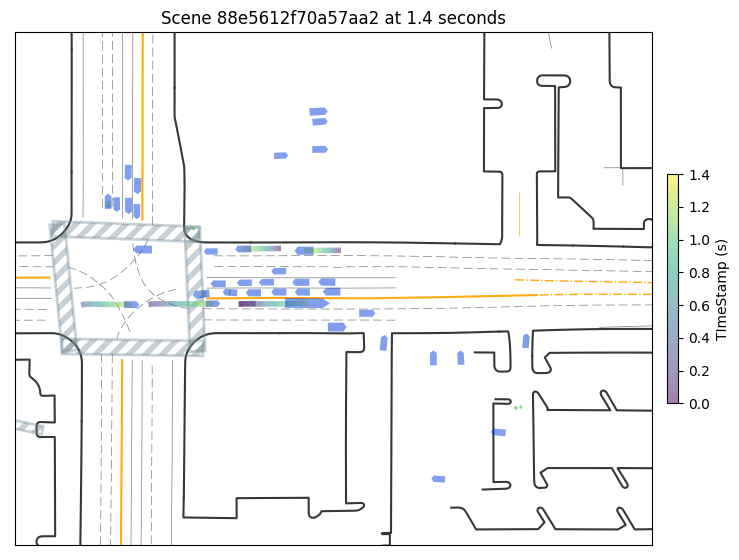

In [129]:
data_batch = env.batch_scene_data
action = model.sample(data_batch)[-1]
env.visualize()
print(action)
_ = env.step(action)

In [134]:
from mtr.models.utils import common_layers
import torch

class test(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.query = torch.nn.Parameter(torch.randn((2,4)), requires_grad=True)
        self.model = common_layers.build_mlps(c_in = 4, mlp_channels=[8,4], ret_before_act=True, activation='elu')
        
    def forward(self):
        return self.model(self.query)

model = test()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [138]:
model.zero_grad()
b = model()
loss = torch.abs(b-1).mean()
loss.backward()
optimizer.step()
print(loss, model.query)


tensor(0.9687, grad_fn=<MeanBackward0>) Parameter containing:
tensor([[-0.3499,  0.9735,  0.2286, -0.6830],
        [ 1.1687,  0.1663, -0.0511,  0.4827]], requires_grad=True)
